# Импорты

In [8]:
import numpy as np
import numpy.ma as ma
import scipy as sp
from functools import cmp_to_key

In [9]:
from numpy.linalg import det, inv, norm, matrix_rank as rk
from scipy.linalg import lu

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# Выпуклая оболочка в $n$-мерном пространстве

Нам необходимо реализовать алгоритм quick hull в $n$-мерном пространстве.


# Геометрические понятия

* Симплекс (точнее, $n$-симплекс, где число $n$ называется размерностью симплекса) — это выпуклая оболочка $n+1$ точки аффинного пространства (размерности n или больше), которые предполагаются аффинно независимыми (то есть не лежат в подпространстве размерности $n–1$). Эти точки называются вершинами симплекса.
* Многогранник (син. политоп, многогранник, полиэдр, англ. polytope, polyhedron) определяется как минимум $n+1$ аффинно независимой точкой (вершиной); симплекс (англ. simplicial polytope) — простейший случай $n$-мерного тела, многогранники с меньшим числом вершин обязательно будут иметь нулевой $n$-мерный объём.
* Параллелотоп (англ. parallelotope) — обобщение плоского параллелограмма и объёмного параллелепипеда. Для симплекса можно построить $n+1$ соответственных параллелотопов (все они будут иметь одинаковый объём, равный $n!$ объёмам симплекса), взяв в качестве образующих (векторов) параллелотопа вектора, выходящие из одной фиксированной вершины в остальные $n$ вершины.
* Симплициальная грань (англ. simplicial facet) определяется $n$ аффинно независимыми точками (вершинами). Далее речь будет идти только о симплициальных объектах (кроме выпуклого многогранника), так что определение «симплициальный» я буду опускать. Многие утверждения в дальнейшем будут справедливы только для невырожденных (все точки попарно различны) случаев симплициальных геометрических объектов.
* Ребро (англ. ridge) определяется как пересечение двух граней и имеет $n–1$ вершину. Две грани могут иметь только одно общее ребро. Одна грань, таким образом, может иметь $n$ соседей через рёбра.
* Горизонт (англю horizont) определим как множество рёбер, которые являются пересечениями грани, невидимой из данной точки и грани, видимой из неё.

Грань многогранника, её границы, границы её границ и т.д. на английском именуются face.  Английский термин facet — это  наблюдаемая грань. Прямая (англ. straight line) — это всегда одномерная сущность. Точку (вершину) можно в этой градации считать нуль-мерной.

## Гиперобъём

Любой рассмотреный объект из ряда симплекс, грань, ребро, пик и т.д. ограничены в соответственном подпространстве. «Количество места», которое такой объект занимает, можно измерить/определить/задать. Для одномерной прямой мера называется длиной; для двумерной плоскости, мера называется площадью; для трёхмерного тела — объём. Понятие можно обобщить, назвав D-мерным объёмом или D-гиперобъёмом. Для симплекса, образованного попарно различными точками $(p_1, p_2,...,p_{n-1}, p_{n+1})$ (порядок перечисления точек важен), гиперобъём вычислить можно так:
$p_i = (p_i^1, p_i^2,...,p_i^n), i \in \{1,2,...n,n+1\}$

$\Delta{p_i} = (\Delta{p_i^1}, \Delta{p_i^2},...,\Delta{p_i^n}) = p_i - p_{n+1}, i \in \{1,2,...n,n+1\}$

$volume(conv(p_1,p_2, ..., p_n, p{n+1})) = \frac{1}{n!} \begin{bmatrix}
 \Delta{p_1^1}&\Delta{p_1^2}&\dots&\Delta{p_1^n}\\ 
 \Delta{p_2^1}&\Delta{p_2^2}&\dots&\Delta{p_2^n}\\
 \vdots&\vdots&\ddots&\vdots\\
 \Delta{p_n^1}&\Delta{p_n^2}&\dots&\Delta{p_n^n}\\ 
\end{bmatrix}$

Здесь мы выписали координаты векторов в строки. Аналогичные формулы и рассуждения можно привести и для векторов-столбцов (т.е. если мы транспонируем все матрицы, то на результат и выводы это не повлияет).
Делитель детерминанта в формуле выше — это количество симплексов (все они имеют одинаковый объём), на который можно разбить параллелотоп $\{\sum_{i=1}^{n} \overrightarrow{\Delta{p_i}}|\; 0 \leq c_i \leq 1\}$, построенный на векторах $ \overrightarrow{\Delta{p_i}}$. Соответственно сам детерминант — это гиперобъём параллелотопа. Интересующимся основаниями, лежащими в основе этого утверждения, рекомендую прочитать про определитель матрицы Грама и о его геометрической интерпретации.
Следует отметить, что данная мера для «объёмных» объектов будет иметь ненулевое значение, а также может быть как положительной, так и отрицательной величиной. Понять смысл знака нетрудно из следующих соображений: при обмене местами двух точек симплекса мы получаем смену знака детерминанта; порядок точек — это «лево- и право- ориентированность» симплекса. На плоскости это несложно себе представить: если стороны треугольника $(1,0),(0,1),(0,0)$ перечислены против часовой стрелки $((1,0),(0,1),(0,0))$, то определитель положителен 
$\begin{bmatrix}
1&0\\
0&1
\end{bmatrix} > 0$, иначе $((0,1),(1,0),(0,0))$ — отрицателен $\begin{bmatrix}
0&1\\
1&0
\end{bmatrix} < 0$. Для тетраэдра знак будет зависеть от того, в каком порядке (по часовой стрелке или против) первые 3 точки будут перечисляться при взгляде на них из последней. Таким образом, в дальнейшем, при задании геометрических объектов, мы должны принять, что порядок перечисления точек должен быть фиксированным.
Множитель перед детерминантом мы можем опустить, так как в алгоритме будет использоваться лишь информация о знаке величины ориентированного гиперобъёма.
Детерминант равен нулю, если хотя бы две строки линейно зависимы (помним, что точки попарно различны, то есть ни одна строка не нулевая). Несложно проверить соответствие приведённых выше рассуждений об аффинно зависимых точках и линейно зависимых векторах, соответствующих им.
На абсолютное значение детерминанта не будет влиять то, какую именно точку вычитаем при переходе к векторам, — только на знак. Следует вычитать всегда последнюю точку из первых, иначе для одинаково ориентированных аналогичных объектов, используемых в дальнейшем, знак меры будет разным в чётных и нечётных размерностях.
Что же делать с мерой для объектов, вложенных в пространство слишком большой размерности, например, с гранями? Если мы сконструируем матрицу так же, как это показано выше, то она будет прямоугольная. Детерминант от такой матрицы взять не получится. Оказывается формулу можно обобщить (это обобщение связано с формулой Бине-Коши), используя всё ту же матрицу составленную из векторов-строк:
$p_i = (p_i^1, p_i^2,...,p_i^n), i \in \{1,2,...m-1,m\}, m \leq n$

$P = (p_1, p_2, \dots, p_m)$

$\Delta{p_i} = (\Delta{p_i^1}, \Delta{p_i^2},...,\Delta{p_i^n}) = p_i - p_{m}, i \in \{1,2,...m-1\}$

$ G(p_1, p_2, p_{m-1}, p_m) =
\begin{bmatrix}
 \Delta{p_1^1}&\Delta{p_1^2}&\dots&\Delta{p_1^n}\\ 
 \Delta{p_2^1}&\Delta{p_2^2}&\dots&\Delta{p_2^n}\\
 \vdots&\vdots&\ddots&\vdots\\
 \Delta{p_{m-1}^1}&\Delta{p_{m-1}^2}&\dots&\Delta{p_{m-1}^n}\\ 
\end{bmatrix} $
$ measure(conv(p_1, p_2, \dots, p_{m-1}, p_m)) = \frac{1}{(m-1)!}\cdot\sqrt{det \mid\mid G(P)\cdot G^{\top}(P) \mid\mid}$

Для аффинно независимых попарно различных точек матрица под детерминантом всегда получается квадратной положительно определённой, а сам детерминант такой матрицы — число всегда положительное. Для аффинно зависимых точек матрица получится сингулярной (т.е. её определитель равен нулю). Ясно, что мера всегда неотрицательная и информации об ориентации мы не имеем.
С одной стороны, детерминант произведения квадратных матриц равен произведению детерминантов, с другой — детерминант транспонированной квадратной матрицы совпадает с детерминантом исходной, таким образом последняя формула сводится к формуле для точки, за исключением корня из квадрата, т.е. модуля, который мы можем опустить, с целью получить дополнительную информацию об относительной ориентации точек в пространстве.

## Ориентация точки относительно грани.

>Точка $p$ лежит выше грани $F$, если гиперобъём симплекса, образованного точкой и гранью положителен, лежит ниже, если гиперобъём отрицателен, на грани, если гиперобъём равен нулю.

# Алгоритм
Авторы описали алгоритм следующим образом:

Смысл алгоритма в том, что мы берём некий изначальный симплекс, постепенно достраивая его до внешней оболочки.

Опишем алгоритм более подробно:
1. Возьмём стартовый симплекс из $n+1$ вершины
2. Для каждой грани создадим множество внешних точек лежащих выше неё. Будем добавлять только ещё не рассмотренные точки. 
3. Для каждой выберем самую дальнюю от неё точку $p$. Создадим множество $V$ видимых из данной точки граней и добавим изначально в него рассматриваемую грань и добавим затем в него соседей, для которых $p$ лежит выше них, дальше будем смотреть соседей соседей, и.т.д. пока не найдём все. Множество рёбер горизонта $H$ будет границей множества $V$. Далее для каждого ребра в $H$ составим новую грань из него и точки $p$. Для каждой новой грани найдём множество внешних точек. Удалим грани, которые есть в $V$ и добавим новые на их замену.
4. Будем продолжать пункт 3, пока не получим выпуклую оболочку.

### Tеорема 1(Упрощённая теорема Бенеза-Бейонда)

 >Пусть $H$ выпуклая оболочка в $R^n$, $p$ точка в  $R^n - H$. Тогда $F$ грань выпуклой оболочки $p \cup H$ тогда и только тогда, когда:
 1. $F$ грань $H$ и $p$ ниже $F$, или
 2. $F$ не грань $H$ и её вершины — вершина $p$ и вершины ребра $H$ с одной инциндентной гранью под $p$ и другой инциндентной гранью над $p$.

### Лемма

$\triangleright$

1. В противном случае мы можем построить новые грани, вместо $F$, которые будут гранями выпуклой оболочки, и которые собой закроют $F$, а значит $F$ не будет гранью выпуклой оболочки.
2. В этом случае $p$ находится вне $H$, а значит $p$ будет точкой выпуклой оболочки $p \cup H$, и будут какие-то грани из $H$, для которых $p$ будет выше них, и можно найти ребро, которое будет граничить с гранями, точка $p$ будет выше одного, и ниже другого, и эта грань $H$ под точкой $p$ будет лежать под гранью образованной этим ребром и $p$.

$\triangleleft$

>Если крайняя точка входных данных выше двух или более граней, то она будет добавлена в оболочку независимо от того, в какое множество внешник точек она попала.

$\triangleright$

Предположим обратное и рассмотрим крайнюю точку $p$, которая не относится к множеству внешних точек и следовательно не будет никогда добавлена в выпуклую оболочку. Поскольку $p$ это крайняя точка, она должна быть по крайней мере вне одной грани начального симплекса. По предположению, существует точка $q$ c $p$ во внешнем видимом множестве, но не в одном из новых внешних множеств. Значит $p$ выше видимой грани и ниже всех новых граней для $q$. Это означает, что $p$ внутри выпуклой оболочки, и не является крайней точкой. Получили противоречие.

$\triangleleft$

### Теорема 2

>Алгоритм Quick Hull строит выпуклую оболочку множества точек в $R^n$.

$\triangleright$

Quickhull начинает с выпуклой оболочкой $n + 1$ точки. Затем он распределяет точки по множества внешних точек и и выбирает наиболее удалённые для обработки. По лемме крайняя точка обязательно будет обработана. Алгоритм обрабатывает точки согласно теореме 1. Он сохраняет точки описанные в части 1 и строит новые грани, как описано в части 2.  Алгоритм строит выпуклую оболочку обработанных точек, значит обработав последнюю точку мы получим выпуклую оболочку точек из входных данных. 

$\triangleleft$

## Время работы

>Максимальное число граней $r$ вершин $f_r = O(r^{\lfloor n/2 \rfloor} / {\lfloor n/2 \rfloor!})$

### Условие сбалансированности

>Выполнение Quick Hull сбалансированно, если 
> * Среднее число новых граней для $j$-той обработанной точки $nf_j/j$
> * Среднее число разделённых точек для $j$-той обработанной точки $n(m - j)/j$

### Теорема

Пусть $m$ число данных точек в $R^n$ и $r$ число обработанных точек. Если условие сбалансированности выполняется, то худшее время работы Quickhull $O(m \log r)$ для $n \leq 3$ и $O(mf_r/r)$ для $n \geq 4$.

$\triangleright$

 В Quick hull две весомые операции: добавление точки и разделение точек. Основная стоимость добавления точки $O(n^3)$ для создания гиперплоскости. Основная стоимость разделения точек $O(n)$ для вычисления расстояний. Суммарная стоимость добавления точек пропорциональна числу всех созданных новых граней, $O(n^3 \sum_{j = 1}^{r}nf_j/j)$. Это упрощается до $O(f_r)$(каждый член меньше $nf_j/r$ и $\lfloor n/2 \rfloor!$ знаменатель $f_r$ включает $d^4$).
 
 Стоимость разделения одной точки за итерацию пропорционально числу новых граней. Суммарная стоимость $O(n \sum_{j=1}^r(m-j)f_j/j^2)$. Раскрывая $f_j$ получим $O(n^3m \sum_{j=1}^r j^{\lfloor n/2 \rfloor}/{\lfloor n/2 \rfloor!})$. Если $n \leq 3$, сумма будет $O(m \log r)$. Иначе каждый член меньше чем $f_r/r^2$ и сумма равна $O(mf_r/r)$.
 
 Если $r = m$ и условие сбалансированности выполняется, время работы Quick hull $O(m \log m)$ для $n \leq 3$ и $O(f_m)$ для $n \geq 4$.
 
 В Quick hull, дальняя внешняя точка не всегда самая дальняя точка от грани, но в большинстве случаев самая дальняя и  являяется крайней точкой. Если точка не крайняя, то более поздняя точка удалит её. Крайняя точка, что удалит несколько вершин встречается очень нечасто. По этим причнам сделаем следующее предположение.
 
$\triangleleft$

#### Предположение

> Пусть $m$ точек входных данных в пространстве $R^n$, и $v$ вершин будет на выходе. Quick hull будет раотать в среднем $O(m \log v)$ для $n \leq 3$ и $O(mf_v/v)$ для $n \geq 4$.

## Пример реализации

Для начала, без ограничения общности, будем считать, что $n < m$, где $m$ - количество точек. Так как иначе, все точки принадлежат выпуклой оболочке.                           
Пример реализации будет приведён для двухмерного случая.

In [11]:
def quick_hull(points):
    """
    :param points набор точек, для которого необходимо посчитать выпуклую оболочку.
            должен иметь форму (n, dim), где dim - размерность пространства.
    """
    n, dim = points.shape
    convex_hull = np.array([]).reshape((-1, dim))

    # Функция вычисляем гиперобъём
    #(пользуемся тем, что у нас размерность пространства 2 и считаем черрез косое произведение)
    def hypervolume(p1, p2, p):
        return (p[0] - p1[0]) * (p2[1] - p1[1]) - (p[1] - p1[1]) * (p2[0] - p1[0])

    # Строим начальный симплекс
    # Берём две крайние точки(они точно входят в оболочку)
    convex_hull = np.vstack([convex_hull, points[np.argmin(points[:, 0]), :]])
    convex_hull = np.vstack([convex_hull, points[np.argmax(points[:, 0]), :]])

    points = np.delete(points, np.argmin(points[:, 0]), 0)
    points = np.delete(points, np.argmax(points[:, 0]), 0)

    max_distance = 0
    max_distance_index = 0

    # Ищем самую дальнюю точку от линии, построенной через две взятые точки
    for index, point in enumerate(points):
        point = np.array(point, copy=True)
        dist = abs(hypervolume(convex_hull[0], convex_hull[1], point))
        if dist > max_distance:
            max_distance_index = index
            max_distance = dist

    convex_hull = np.vstack([convex_hull, points[max_distance_index]])
    points = np.delete(points, np.where(np.all(points == convex_hull[2], axis=1)), 0)

    # Находим по какую сторону он линии через две точки стартового симплекса находится третья и если
    # меняем направления обхода так, чтобы она лежала ниже линии
    distance = hypervolume(convex_hull[0], convex_hull[1], convex_hull[2])
    if (distance > 0):
        convex_hull = np.flip(convex_hull, 0)

    # добавляем начальные грани
    facets = []
    facets.append([convex_hull[0], convex_hull[1]])
    facets.append([convex_hull[1], convex_hull[2]])
    facets.append([convex_hull[2], convex_hull[0]])

    # Заполняем массивы внешних точек
    outside = [[], [], []]
    outside_point = [False for i in range(n)]
    for index, edge in enumerate(facets):
        edge = np.array(edge, copy=True)
        for ind, point in enumerate(points):
            point = np.array(point, copy=True)
            distance = hypervolume(edge[0], edge[1], point)
            if not outside_point[ind] and distance > 0:
                outside[index].append(ind)
                outside_point[ind] = True

    # добавлем грани друг другу в соседи
    neigh = [[1, 2], [0, 2], [1, 0]]
    # массив в котором помечаем, нужна ли нам грань ещё или нет
    banned_facets = [False, False, False]

    # основной цикл
    for index, facet in enumerate(facets):
        facet = np.array(facet, copy=True)
        if banned_facets[index]:
            continue
        if (outside[index]):
            # выбираем самую дальнюю внешнюю точку для грани
            max_distance = -1
            p = None
            for point in outside[index]:
                distance = hypervolume(facet[0], facet[1], points[point])
                if max_distance < distance:
                    max_distance = distance
                    p = point

            # ищем все видимые из точки грани
            visible = [index]
            visited = [False for i in range(len(facets))]
            horizont = []
            for i in visible:
                vcount = 0
                visited[i] = True
                for vfacet in neigh[i]:
                    if not visited[vfacet] and not banned_facets[vfacet]:
                        if hypervolume(facets[vfacet][0], facets[vfacet][1], points[p]) > 0:
                            visible.append(vfacet)
                            vcount += 1
                        else:
                            break
                    else:
                        vcount += 1
                # проверяем ли, является ли грань горизонтом(т.е. за ней ничего не увидим)
                if vcount == len(neigh[i]):
                    # данная грань нам далее не понадобится
                    banned_facets[i] = True
                else:
                    horizont.append(i)

            # для каждой грани горизонта ищем соседние грани, находим общие точки и строим новые грани из общих точек
            # и самой удалённой и добавляем соседей, которые не видны из точки
            for ind in horizont:
                newFacet = None
                for f in neigh[ind]:
                    if not banned_facets[f] and hypervolume(facets[f][0], facets[f][1], points[p]) < 0:
                        if (np.array_equal(facets[f][0], facets[ind][1])):
                            newFacet = [points[p], facets[f][0]]
                            neigh[f].append(len(facets))
                            facets.append(newFacet)
                            neigh.append([f])
                            banned_facets.append(False)
                for f in neigh[ind]:
                    if not banned_facets[f] and hypervolume(facets[f][0], facets[f][1], points[p]) < 0:
                        if (np.array_equal(facets[f][1], facets[ind][0])):
                            newFacet = [facets[f][1], points[p]]
                            neigh[f].append(len(facets))
                            facets.append(newFacet)
                            neigh.append([f])
                            banned_facets.append(False)
                banned_facets[ind] = True

            # для новых граней добавляем друг друга в соседи и строим списки внешних точек
            if len(horizont) > 0:
                outside.append([])
                outside.append([])
                n = len(facets)
                neigh[n - 2].append(n - 1)
                neigh[n - 1].append(n - 2)
                for v in visible:
                    for outpoint in outside[v]:
                        if (hypervolume(facets[n - 2][0], facets[n - 2][1], points[outpoint])) > 0:
                            outside[n - 2].append(outpoint)
                        if (hypervolume(facets[n - 1][0], facets[n - 1][1], points[outpoint])) > 0:
                            outside[n - 1].append(outpoint)
            convex_hull = np.vstack([convex_hull, points[p]])

    # возвращаем построенную оболочку
    return convex_hull

In [12]:
def draw_2d_convex_hull(points, axis=None):
    convex_hull = quick_hull(points)
    # отсортируем точки по полярному углу, для этого ипользуем предикат поворота.
    # будем сортировать не сами точки а их номера.
    indices = range(len(convex_hull))
    def cmp(x, y):
        value = det(convex_hull[[x, y]] - convex_hull[0])
        if np.abs(value) < 10e-8:
            return 0
        return np.sign(value)
    indices = sorted(indices, key=cmp_to_key(cmp))
    #indices = [0] + indices
    indices += [indices[0]]
    # рисуем график
    if axis is None:
        plt.figure(figsize=(6,6))
        plt.scatter(points.T[0], points.T[1], c='r')
        plt.scatter(convex_hull[indices].T[0], convex_hull[indices].T[1], c='g')
        plt.plot(convex_hull[indices].T[0], convex_hull[indices].T[1], c='g')
        plt.title("Convex hull")
        plt.show()
    else:
        axis.scatter(points.T[0], points.T[1], c='r', s=10)
        axis.scatter(convex_hull[indices].T[0], convex_hull[indices].T[1], c='g')
        axis.plot(convex_hull[indices].T[0], convex_hull[indices].T[1], c='g')

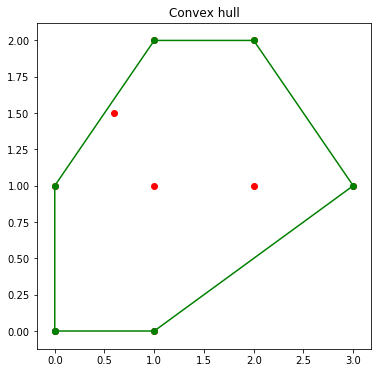

In [13]:
points = np.array([
       [0., 0.],
       [1., 0.],
       [0., 1.],
       [1., 1.],
       [3., 1.],
       [2., 2.],
       [2,   1],
       [1,   2],
       [0.6, 1.5]
])
draw_2d_convex_hull(points)

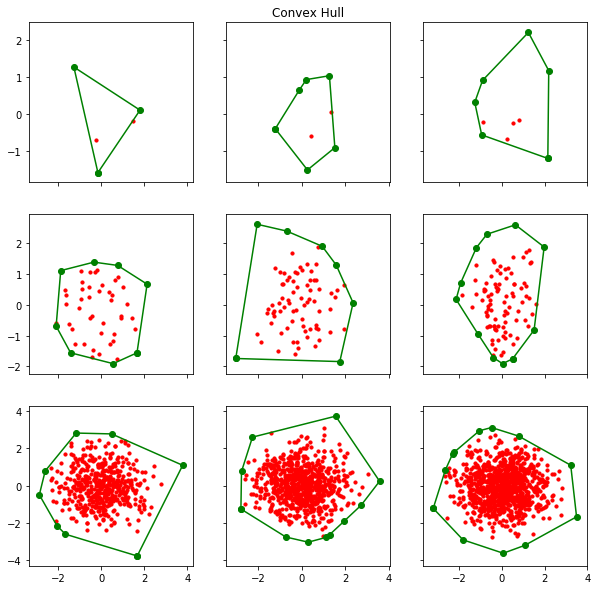

In [14]:
f, axes = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(10, 10))
for axes_row, count_row in zip(axes, [1, 10, 100]):
    for axis, count_col in zip(axes_row, [10, 16, 20]):
        points = np.random.normal(0., 1., count_row * count_col).reshape((int(count_row * count_col / 2), 2))
        draw_2d_convex_hull(points, axis=axis)
axes[0][1].set_title('Convex Hull')